<a href="https://colab.research.google.com/github/catmalark/Tensorflow-My-Practices/blob/main/CatsvsDogsConvNNTransferLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

We will be using small version of the cat vs dogs dataset for testing the power of transfer learning

In [1]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
import numpy as np
import random
from shutil import copyfile

In [2]:
!wget https://storage.googleapis.com/tensorflow-1-public/course2/cats_and_dogs_filtered.zip

--2022-04-21 17:54:55--  https://storage.googleapis.com/tensorflow-1-public/course2/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.135.128, 74.125.142.128, 74.125.195.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.135.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘cats_and_dogs_filtered.zip’

cats_and_dogs_filte 100%[===================>]  65.43M   122MB/s    in 0.5s    

2022-04-21 17:54:56 (122 MB/s) - ‘cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [3]:
import zipfile

# Unzip the dataset
zip_ref = zipfile.ZipFile("./cats_and_dogs_filtered.zip", 'r')
zip_ref.extractall("tmp/")
zip_ref.close()

In [4]:
import os

# Define our example directories and files
base_dir = 'tmp/cats_and_dogs_filtered'

train_dir = os.path.join( base_dir, 'train')
validation_dir = os.path.join( base_dir, 'validation')

# Directory with training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats') 

# Directory with training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs') 

# Directory with validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats') 

# Directory with validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

print('total training cat images:', len(os.listdir(train_cats_dir)))
print('total training dog images:', len(os.listdir(train_dogs_dir)))

total training cat images: 1000
total training dog images: 1000


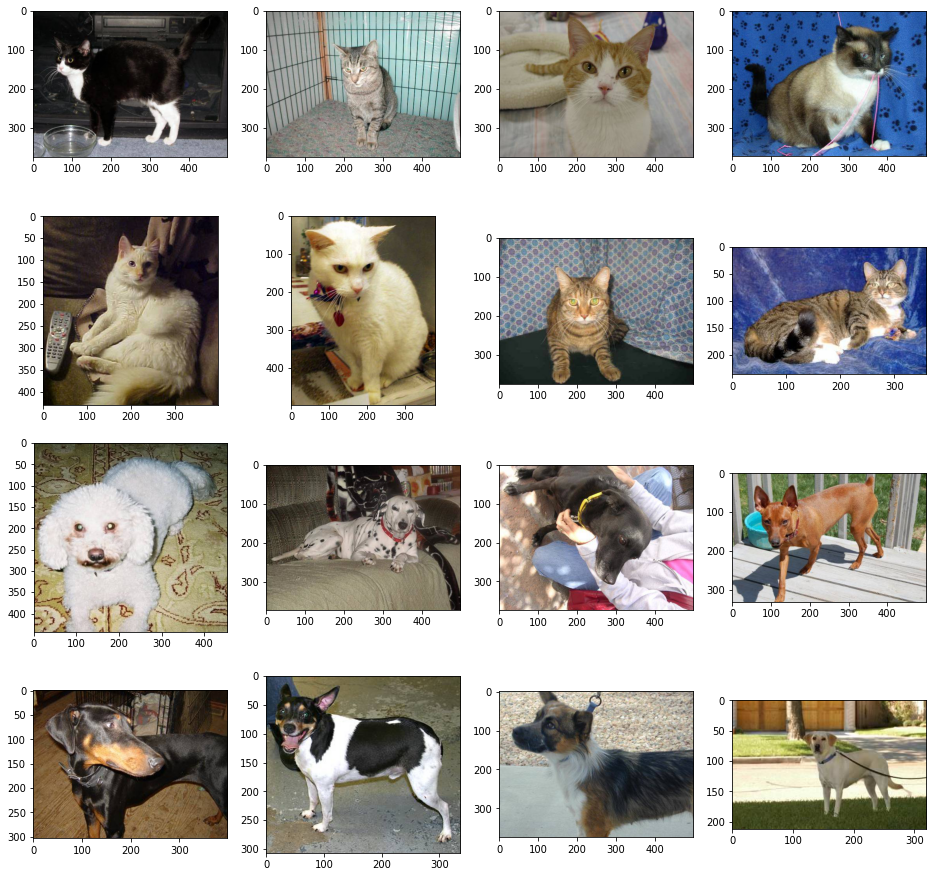

In [5]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

# Index for iterating over images
pic_index = 0

fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

pic_index += 8
next_cat_pix = [os.path.join(train_cats_dir, fname) 
                for fname in os.listdir(train_cats_dir)[pic_index-8:pic_index]]
next_dog_pix = [os.path.join(train_dogs_dir, fname) 
                for fname in os.listdir(train_dogs_dir)[pic_index-8:pic_index]]

for i, img_path in enumerate(next_cat_pix+next_dog_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('On') 

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()


In [6]:
#Pre Proccesing
from keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1/255,
                                     rotation_range=40,
                                     width_shift_range=0.2,
                                     height_shift_range=0.2,
                                     shear_range=0.2,
                                     zoom_range=0.2,
                                     horizontal_flip=True,
                                     fill_mode="nearest")

train_generator = train_datagen.flow_from_directory(directory=train_dir,
                                                      batch_size=64,
                                                      class_mode="binary",
                                                      target_size=(150, 150))


validation_datagen = ImageDataGenerator(rescale=1/255)

validation_generator = validation_datagen.flow_from_directory(directory=validation_dir,
                                                                batch_size=64,
                                                                class_mode="binary",
                                                                target_size=(150, 150))

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [7]:
#Now we will create pre-trained model, inceptionv3

# Download the inception v3 weights
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2022-04-21 17:55:06--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.135.128, 74.125.142.128, 74.125.195.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.135.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M   123MB/s    in 0.7s    

2022-04-21 17:55:06 (123 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [8]:
from keras.applications.inception_v3 import InceptionV3

local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

pre_trained_model = InceptionV3(input_shape = (150, 150, 3),
                                  include_top = False, 
                                  weights = None) 

pre_trained_model.load_weights(local_weights_file)

for layer in pre_trained_model.layers: #Making all layers untrainable
    layer.trainable = False

In [9]:
last_layer = pre_trained_model.get_layer('mixed7')      #making the last layer mixed 7 which is 7x7 conv
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 7, 7, 768)


In [10]:
x = layers.Flatten()(last_output)
x = layers.Dense(1024, activation="relu")(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

model = keras.Model(inputs=pre_trained_model.input, outputs=outputs)

model.compile(optimizer=keras.optimizers.Nadam(learning_rate=0.0001),
                loss="binary_crossentropy",
                metrics=['accuracy']) 

In [ ]:
model.summary()

In [12]:
#Callback Function
class myCallback(tf.keras.callbacks.Callback):
        def on_epoch_end(self, epoch, logs={}):
            if logs.get('accuracy') >= 0.999: 
                print("\nReached 99.9% accuracy so cancelling training!") 
                self.model.stop_training = True

In [14]:
callbacks = myCallback()

history = model.fit(
      train_generator,
      epochs=10,
      verbose=1,
      validation_data = validation_generator,    
      callbacks=[callbacks]
      )

Epoch 1/10
32/32 [==============================] - 19s 603ms/step - loss: 0.0962 - accuracy: 0.9620 - val_loss: 0.0818 - val_accuracy: 0.9680
Epoch 2/10
32/32 [==============================] - 19s 607ms/step - loss: 0.0972 - accuracy: 0.9610 - val_loss: 0.1078 - val_accuracy: 0.9540
Epoch 3/10
32/32 [==============================] - 22s 676ms/step - loss: 0.0937 - accuracy: 0.9590 - val_loss: 0.0765 - val_accuracy: 0.9760
Epoch 4/10
32/32 [==============================] - 20s 615ms/step - loss: 0.0903 - accuracy: 0.9655 - val_loss: 0.1009 - val_accuracy: 0.9620
Epoch 5/10
32/32 [==============================] - 20s 620ms/step - loss: 0.0957 - accuracy: 0.9645 - val_loss: 0.0994 - val_accuracy: 0.9590
Epoch 6/10
32/32 [==============================] - 20s 617ms/step - loss: 0.0837 - accuracy: 0.9645 - val_loss: 0.0847 - val_accuracy: 0.9660
Epoch 7/10
32/32 [==============================] - 19s 607ms/step - loss: 0.0715 - accuracy: 0.9760 - val_loss: 0.1054 - val_accuracy: 0.9580

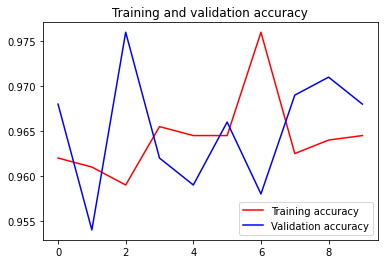

<Figure size 432x288 with 0 Axes>

In [15]:
# Plot the training and validation accuracies for each epoch

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()

In [16]:
#Creating image upload folder
os.makedirs("/tmp/images")

In [17]:
#Now upload and predict your image
from keras.preprocessing import image
import os

images = os.listdir("/tmp/images")

print(images)

for i in images:
  print()
  # predicting images
  path = '/tmp/images/' + i
  img = image.load_img(path, target_size=(150, 150))
  x = image.img_to_array(img)
  x /= 255
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  print(classes[0])
  if classes[0]>0.5:
    print(i + " is a dog")
  else:
    print(i + " is a cat")
 

['IMG_1155.jpeg', 'IMG_1978.jpg', 'PHOTO-2022-04-10-18-03-16.jpg', 'IMG_1156.jpeg']

[0.99766076]
IMG_1155.jpeg is a dog

[1.]
IMG_1978.jpg is a dog

[0.9999951]
PHOTO-2022-04-10-18-03-16.jpg is a dog

[1.]
IMG_1156.jpeg is a dog
